In [2]:
import xarray as xr
import numpy as np
from matplotlib import pyplot as plt
%load_ext memory_profiler

Create INSAR Dataset

In [13]:
# Set data cube dimension
n_azimuth=2000
n_range=1000
n_time=4

In [14]:
# signal
signal = np.zeros((n_time,n_azimuth,n_range))
signal[0,:,:] = np.tile(np.linspace(0,np.pi,num=n_range), (n_azimuth,1))
for i in range(1,n_time):
    signal[i,:,:] = signal[0,:,:]+i

# noise
np.random.seed(0)
noise = np.random.rand(n_time,n_azimuth,n_range)*2*np.pi

# obs
obs = signal + noise

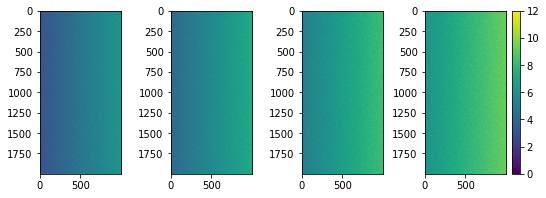

In [19]:
fig, ax = plt.subplots(1,n_time)
fig.set_size_inches(9,3)
for i in range(n_time):
    im = ax[i].imshow(obs[i], vmin=0, vmax=12)
plt.colorbar(im)

In [15]:
ds = xr.Dataset(
    data_vars=dict(
        obs=(["time", "azimuth", "range"], obs),
    ),
    coords=dict(
        azimuth=np.arange(n_azimuth),
        range=np.arange(n_range),
        time=np.arange(n_time),
    ),
)
ds

<xarray.Dataset>
Dimensions:  (time: 4, azimuth: 2000, range: 1000)
Coordinates:
  * azimuth  (azimuth) int64 0 1 2 3 4 5 6 ... 1994 1995 1996 1997 1998 1999
  * range    (range) int64 0 1 2 3 4 5 6 7 8 ... 992 993 994 995 996 997 998 999
  * time     (time) int64 0 1 2 3
Data variables:
    obs      (time, azimuth, range) float64 3.448 4.497 3.794 ... 8.004 7.702

Create sample contextual raster data-set

In [7]:
# Set contextual raster data cube dimension
n_azimuth_ci=750
n_range_ci=750
n_time_ci=4

In [8]:
# signal
signal = np.zeros((n_time_ci,n_azimuth_ci,n_range_ci))
signal[0,:,:] = np.tile(np.linspace(0,np.pi,num=n_range_ci), (n_azimuth_ci,1))
for i in range(1,n_time_ci):
    signal[i,:,:] = signal[0,:,:]+i

# noise
np.random.seed(0)
noise = np.random.rand(n_time_ci,n_azimuth_ci,n_range_ci)*2*np.pi

# obs
obs_ci = signal + noise

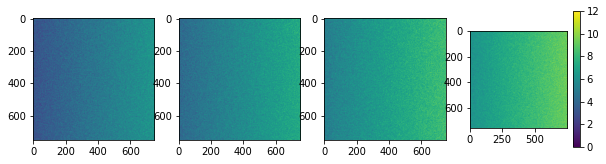

In [26]:
fig, ax = plt.subplots(1,n_time_ci)
fig.set_size_inches(10,2.5)
for i in range(n_time_ci):
    im = ax[i].imshow(obs_ci[i], vmin=0, vmax=12)
plt.colorbar(im)

In [16]:
ds_ci = xr.Dataset(
    data_vars=dict(
        CI_temp=(["time", "azimuth", "range"], obs_ci),
    ),
    coords=dict(
        azimuth=np.arange(n_azimuth_ci)*(n_azimuth/n_azimuth_ci),
        range=np.arange(n_range_ci)*(n_range/n_range_ci),
        time=np.arange(n_time_ci)*(n_time/n_time_ci),
    ),
)
ds_ci

<xarray.Dataset>
Dimensions:  (time: 4, azimuth: 750, range: 750)
Coordinates:
  * azimuth  (azimuth) float64 0.0 2.667 5.333 ... 1.992e+03 1.995e+03 1.997e+03
  * range    (range) float64 0.0 1.333 2.667 4.0 ... 994.7 996.0 997.3 998.7
  * time     (time) float64 0.0 1.0 2.0 3.0
Data variables:
    CI_temp  (time, azimuth, range) float64 3.448 4.498 3.796 ... 10.37 7.203

Select closest CI for INSAR coordinates with xarray_sel( ) from raster SAR data (i.e with sparse representation)

*** Note that the resultant coordinate system is of the CI dataset from which we are selecting

In [11]:
ds_ci_sel = ds_ci.sel(azimuth = ds['azimuth'], range = ds['range'], method = 'nearest')
ds_ci_sel

<xarray.Dataset>
Dimensions:  (time: 4, azimuth: 5000, range: 5000)
Coordinates:
  * azimuth  (azimuth) float64 0.0 0.0 0.0 0.0 ... 1.997e+03 1.997e+03 1.997e+03
  * range    (range) float64 0.0 0.0 0.0 0.0 1.333 ... 998.7 998.7 998.7 998.7
  * time     (time) float64 0.0 1.0 2.0 3.0
Data variables:
    CI_temp  (time, azimuth, range) float64 3.448 3.448 3.448 ... 7.203 7.203

Select closest CI for SAR coordinates and reindex to SAR coordinates with xarray_reindex( ) from raster SAR data (i.e with sparse representation)

*** Note that the resultant coordinate system is now the same as the SAR coordinate system

In [12]:
ds_ci_reind = ds_ci.reindex(azimuth = ds['azimuth'], range = ds['range'], method = 'nearest')
ds_ci_reind

<xarray.Dataset>
Dimensions:  (azimuth: 5000, range: 5000, time: 4)
Coordinates:
  * azimuth  (azimuth) float64 0.0 0.4 0.8 1.2 ... 1.999e+03 1.999e+03 2e+03
  * range    (range) float64 0.0 0.2 0.4 0.6 0.8 ... 999.2 999.4 999.6 999.8
  * time     (time) float64 0.0 1.0 2.0 3.0
Data variables:
    CI_temp  (time, azimuth, range) float64 3.448 3.448 3.448 ... 7.203 7.203

CI raster data import for point-set from SAR data-set

In [20]:
# Select the low std pixels
mask = ds.obs.std(axis=0)<0.5
print(mask.sum())
ds_masked = ds.where(mask)
pointset = ds_masked.stack(points=('azimuth', 'range'))
pointset = pointset.dropna('points', subset=['obs'])
pointset

<xarray.DataArray 'obs' ()>
array(34885)


<xarray.Dataset>
Dimensions:  (time: 4, points: 34885)
Coordinates:
  * time     (time) int64 0 1 2 3
  * points   (points) object MultiIndex
  * azimuth  (points) int64 0 0 0 0 0 0 0 ... 1999 1999 1999 1999 1999 1999 1999
  * range    (points) int64 20 71 163 165 244 281 ... 743 768 769 850 905 948
Data variables:
    obs      (time, points) float64 6.212 3.168 5.956 ... 6.254 8.466 6.026

In [23]:
pointset.points['azimuth']

<xarray.DataArray 'azimuth' (points: 34885)>
array([   0,    0,    0, ..., 1999, 1999, 1999])
Coordinates:
  * points   (points) object MultiIndex
  * azimuth  (points) int64 0 0 0 0 0 0 0 ... 1999 1999 1999 1999 1999 1999 1999
  * range    (points) int64 20 71 163 165 244 281 ... 743 768 769 850 905 948

In [24]:
ds_ci_ps_sel = ds_ci.sel(azimuth = pointset.points['azimuth'], range = pointset.points['range'], method = 'nearest')
ds_ci_ps_sel

<xarray.Dataset>
Dimensions:  (time: 4, points: 34885)
Coordinates:
    azimuth  (points) float64 0.0 0.0 0.0 0.0 ... 1.997e+03 1.997e+03 1.997e+03
    range    (points) float64 20.0 70.67 162.7 165.3 ... 769.3 850.7 905.3 948.0
  * time     (time) float64 0.0 1.0 2.0 3.0
    points   (points) object (0, 20) (0, 71) ... (1999, 905) (1999, 948)
Data variables:
    CI_temp  (time, points) float64 0.6104 0.8635 6.519 ... 6.645 8.135 6.351

In [ ]:
ds_ci_ps_reind = ds_ci.reindex(azimuth = pointset.points['azimuth'], range = pointset.points['range'], method = 'nearest')
ds_ci_ps_reind

In [37]:
pointset['CI_temp'] = ds_ci_ps_sel['CI_temp']
pointset

<xarray.Dataset>
Dimensions:  (time: 4, points: 34885)
Coordinates:
  * time     (time) int64 0 1 2 3
  * points   (points) object MultiIndex
  * azimuth  (points) int64 0 0 0 0 0 0 0 ... 1999 1999 1999 1999 1999 1999 1999
  * range    (points) int64 20 71 163 165 244 281 ... 743 768 769 850 905 948
Data variables:
    obs      (time, points) float64 6.212 3.168 5.956 ... 6.254 8.466 6.026
    CI_temp  (time, points) float64 0.6104 0.8635 6.519 ... 6.645 8.135 6.351